In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import math

In [28]:
# All the code you need to run the inference and generate images!

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = ("cpu")
    x = torch.ones(1, device=device)
    print (x)
    
def show_images(images, num_images=16, figsize=(10,10)):
    images = images.cpu().detach()
    
    images = (images + 1) / 2
    
    images = torch.clamp(images, 0, 1)
    
    grid = torchvision.utils.make_grid(images[:num_images], nrow=4)
    
    grid = grid.numpy().transpose((1, 2, 0))
    
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

class EqualLRConv2d(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True
    ):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        )
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))

        else:
            self.bias = None

    def forward(self, input):
        out = F.conv2d(
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},"
            f" {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})"
        )

class EqualLRLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=0.01, activation=None  # lr_mul from rosinality 
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = nn.Parameter(torch.zeros(out_dim))

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation: 
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)
        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})"
        )
    
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True)
                                  + 1e-8)

class LearnedConstant(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        
        self.constant = nn.Parameter(torch.randn(1, in_c, 4, 4))
        
    def forward(self, batch_size):
        return self.constant.expand(batch_size, -1, -1, -1)

class NoiseLayer(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))
    
    def forward(self, gen_image, noise=None):
        if noise is None:
            N, _, H, W = gen_image.shape
            noise = torch.randn(N, 1, H, W, device=gen_image.device)
        
        return gen_image + (noise * self.weight)

class MappingNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.norm = PixelNorm()
        
        self.layers = nn.Sequential(
            EqualLRLinear(512, 512),
            nn.LeakyReLU(0.2),
            EqualLRLinear(512, 512),
            nn.LeakyReLU(0.2),
            EqualLRLinear(512, 512),
            nn.LeakyReLU(0.2),
            EqualLRLinear(512, 512),
            nn.LeakyReLU(0.2),
            EqualLRLinear(512, 512),
            nn.LeakyReLU(0.2),
            EqualLRLinear(512, 512),
            nn.LeakyReLU(0.2),
            EqualLRLinear(512, 512),
            nn.LeakyReLU(0.2),
            EqualLRLinear(512, 512),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        x = self.norm(x)
        
        out = self.layers(x)
        
        return out
    
class Blur(nn.Module):
    def __init__(self):
        super().__init__()
        f = torch.Tensor([1, 3, 3, 1])
        self.register_buffer('f', f)

    def forward(self, x):
        f = self.f
        f = f[None, None, :] * f[None, :, None]
        f = f / f.sum()
        return F.conv2d(x, f.expand(x.size(1), -1, -1, -1), 
                        groups=x.size(1), padding=1)

class Conv2d_mod(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, latent_dim, padding):
        super().__init__()
        
        self.weight = nn.Parameter(
            torch.randn(1, out_channels, in_channels, kernel_size, kernel_size)
        )
        
        self.scale = 1 / math.sqrt(in_channels * kernel_size ** 2)
        
        self.modulation = EqualLRLinear(latent_dim, in_channels, bias_init=1)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2

    def forward(self, x, style):
        batch, channels, height, width = x.shape
        
        style = self.modulation(style).view(batch, 1, -1, 1, 1)
        
        weight = self.scale * self.weight * style
        
        demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
        weight = weight * demod.view(batch, self.out_channels, 1, 1, 1)
        
        weight = weight.view(
            batch * self.out_channels, self.in_channels, 
            self.kernel_size, self.kernel_size
        )
        
        x = x.view(1, batch * channels, height, width)
        out = F.conv2d(
            x, 
            weight,
            padding=self.padding,
            groups=batch
        )
        
        _, _, height, width = out.shape
        out = out.view(batch, self.out_channels, height, width)
        
        return out

class g_style_block(nn.Module):
    def __init__(
        self, 
        in_c, 
        out_c, 
        ksize1, 
        padding,
        upsample=True,
        latent_dim=512,
    ):
        super().__init__()

        layers_list = []

        if upsample:
            layers_list.extend([
                nn.Upsample(scale_factor=2, mode='bilinear'),
                Conv2d_mod(in_c, out_c, ksize1, latent_dim, padding=padding),  # Will need to provide style_w and x
                NoiseLayer(out_c),
            ])
        else:
            self.learned_constant = LearnedConstant(in_c)

        layers_list.extend([
            nn.LeakyReLU(0.2),
            Conv2d_mod(out_c, out_c, ksize1, latent_dim, padding=padding),
            NoiseLayer(out_c),
            nn.LeakyReLU(0.2),
        ])

        self.layers = nn.ModuleList(layers_list)
        self.upsample = upsample
        
    def forward(self, w, x=None):
        if not self.upsample:
            x = self.learned_constant(w.size(0))
        
        for layer in self.layers:
            if isinstance(layer, LearnedConstant):
                x = layer()
            elif isinstance(layer, Conv2d_mod):
                x = layer(x, w)
            else:
                x = layer(x)
            
        return x


class Generator(nn.Module):
    def __init__(self, in_c=512):
        super().__init__()
        
        self.g_mapping = MappingNetwork()

        fmaps = 0.5
        in_c = int(in_c * fmaps)
        
        self.block_4x4 = g_style_block(in_c, in_c, 3, 1, upsample=False)
        self.block_8x8 = g_style_block(in_c, in_c, 3, 1)
        self.block_16x16 = g_style_block(in_c, in_c, 3, 1)
        self.block_32x32 = g_style_block(in_c, in_c, 3, 1)
        self.block_64x64 = g_style_block(in_c, in_c//2, 3, 1)
        self.block_128x128 = g_style_block(in_c//2, in_c//4, 3, 1)
        self.block_256x256 = g_style_block(in_c//4, in_c//4, 3, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.to_rgb_4 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_8 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_16 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_32 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_64 = EqualLRConv2d(in_c//2, 3, 1)
        self.to_rgb_128 = EqualLRConv2d(in_c//4, 3, 1)
        self.to_rgb_256 = EqualLRConv2d(in_c//4, 3, 1)
                
        self.tanh = nn.Tanh()
    def forward(self, z, return_latents=False):
        w = self.g_mapping(z)
        batch_size = z.size(0)
        
        mixing = torch.rand(batch_size, device=z.device) < 0.9
        
        z2 = torch.randn_like(z)
        w2 = self.g_mapping(z2)
        
        crossover_points = torch.randint(1, 7, (batch_size,), device=z.device)
        
        styles = []
        
        for layer_idx in range(7):
            use_w2 = mixing & (crossover_points <= layer_idx)
            style = torch.where(use_w2.unsqueeze(1), w2, w)
            styles.append(style)
        
        out = self.block_4x4(styles[0])
        out_4 = self.to_rgb_4(out)
        out_4 = self.upsample(out_4)
        
        out = self.block_8x8(styles[1], out)
        out_8 = self.to_rgb_8(out)
        out_8 += out_4 * (1 / np.sqrt(2))
        out_8 = self.upsample(out_8)
        
        out = self.block_16x16(styles[2], out)
        out_16 = self.to_rgb_16(out)
        out_16 += out_8 * (1 / np.sqrt(2))
        out_16 = self.upsample(out_16)
        
        out = self.block_32x32(styles[3], out)
        out_32 = self.to_rgb_32(out)
        out_32 += out_16 * (1 / np.sqrt(2))
        out_32 = self.upsample(out_32)
        
        out = self.block_64x64(styles[4], out)
        out_64 = self.to_rgb_64(out)
        out_64 += out_32 * (1 / np.sqrt(2))
        out_64 = self.upsample(out_64)

        out = self.block_128x128(styles[5], out)            
        out_128 = self.to_rgb_128(out)
        out_128 += out_64 * (1 / np.sqrt(2))
        out_128 = self.upsample(out_128)

        out = self.block_256x256(styles[6], out)
        out_256 = self.to_rgb_128(out)
        out_256 += out_128 * (1 / np.sqrt(2))
        
        if return_latents:
            return out_256, styles[6]
        else:
            return out_256

tensor([1.], device='cuda:0')


In [32]:
g = Generator().to(device)
g_running = Generator().to(device)

# You can download the best checkpoint from huggingface§

In [34]:
checkpoint_path = './best_checkpoint.pth'

print("Loading the best checkpoint!")
checkpoint = torch.load(checkpoint_path, weights_only=False)
g.load_state_dict(checkpoint['g_state_dict'])
g_running.load_state_dict(checkpoint['g_running_state_dict'])
print(f"=> Loaded best checkpoint")

Loading the best checkpoint!
=> Loaded best checkpoint


In [42]:
z = torch.randn(16, 512, device=device)
gen_imgs = g(z)
g_running_gen_imgs = g_running(z)

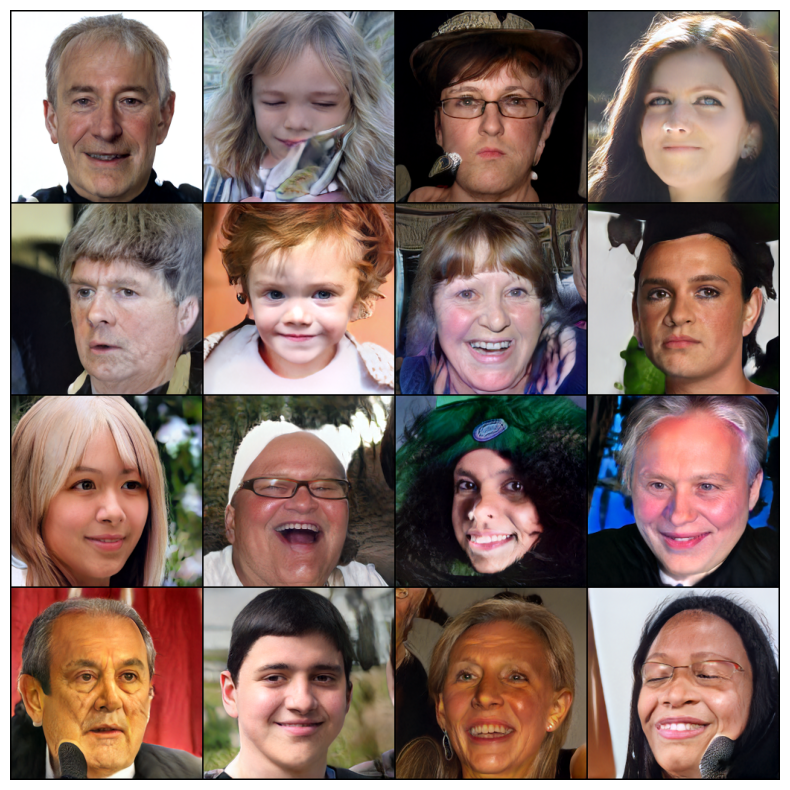

In [43]:
show_images(gen_imgs)

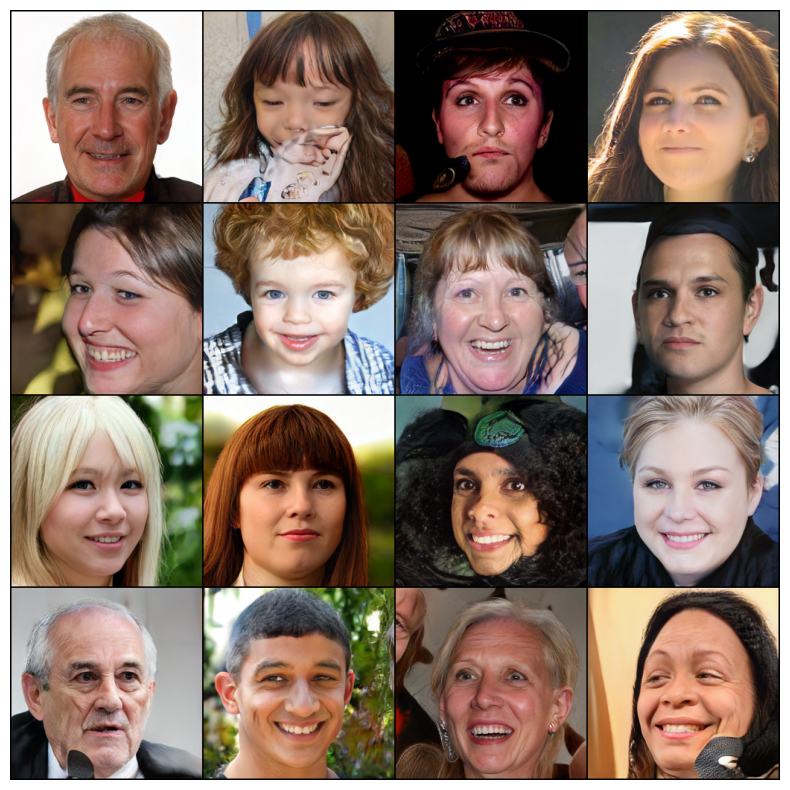

In [44]:
show_images(g_running_gen_imgs)